<a href="https://colab.research.google.com/github/sunjana2199/Deep_Video_Understanding/blob/main/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Dependencies

In [ ]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load
import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/Big Data'

/content/drive/MyDrive/Big Data


#Loading the Images

#Flikr8k Dataset

##Loading the captions and images

In [ ]:
captions_path = '/content/drive/MyDrive/Big Data/captions/captions.txt'
images_path = '/content/drive/MyDrive/Big Data/images'

##Creating a Dataframe

In [ ]:
f = open(captions_path, 'r')
captions = f.read().split("\n")
f.close()

In [ ]:
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [ ]:
ids = []
descs = []
for i in captions[1:-1]:
  # print(i)
  id = i.split(',')[0]
  desc = i.split(',')[1]
  ids.append(id)
  descs.append(desc)

In [ ]:
df = pd.DataFrame()
df['id'] = ids
df['captions'] = descs

In [ ]:
df.head()

,id,captions
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
df.shape

(40455, 2)

## Displaying images from the dataset

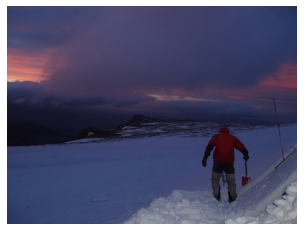

array(['A man is shoveling snow during a sunrise .',
       'A man stands in the snow as the sun sets .',
       'A mist overshadows a man in winter gear and the winter landscape in front of him .',
       'A person stands in a snowy area looking down .',
       'Man walking through the deep snow at dusk .'], dtype=object)

In [ ]:
import random 

sNum = random.randint(0,40455)
k = df['id'][sNum]
PATH = images_path + '/' + k


ex = mpimg.imread(PATH)
plt.imshow(ex);
plt.axis('off')
display.display(plt.gcf())
display.clear_output(wait=True)
plt.show()
ex_cap = df['captions'].loc[df['id'] == k].values
ex_cap

In [ ]:
# Creating a List of Filenames

df['all_ids'] = images_path + '/' + df['id'].astype(str)
images_list = df["all_ids"].tolist()
df = df.drop('all_ids', axis = 1)
images_list[:5]


['/content/drive/MyDrive/Big Data/images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Big Data/images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Big Data/images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Big Data/images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Big Data/images/1000268201_693b08cb0e.jpg']

#Text Preprocessing

- Remove Punctuations
- Remove single letters
- Remove any numbers
- add tags to the text

In [ ]:

def remove_punctuations(text_original):
    for punctuation in string.punctuation:
        text_new = text_original.replace(punctuation, '')
    return text_new

In [ ]:
def remove_single_chars(text_original):
  text_new = ""
  for w in text_original.split():
    if len(w) > 1:
      text_new = text_new + " " + w
  return text_new


In [ ]:
def remove_numbers(text_original) :
   text_new = ""
   for w in text_original.split():

       isalpha = w.isalpha()
       if isalpha:
           text_new += " " + w
   return(text_new)

In [ ]:
def cleaned_text(text_original):
  text = remove_punctuations(text_original)
  text1 = remove_single_chars(text)
  clean_text = remove_numbers(text1)
  return(clean_text)


In [ ]:
for i, caption in enumerate(df.captions.values):
   newcaption = cleaned_text(caption)
   df["captions"].iloc[i] = newcaption

In [ ]:
df.head()

,id,captions
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of sta...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden c...


In [ ]:
df['all_captions'] = '<start>' + df['captions'].astype(str) + "<end>"
captions_list = df["all_captions"].tolist()
df = df.drop('all_captions', axis = 1)
captions_list[:5]


['<start> child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start> girl going into wooden building<end>',
 '<start> little girl climbing into wooden playhouse<end>',
 '<start> little girl climbing the stairs to her playhouse<end>',
 '<start> little girl in pink dress going into wooden cabin<end>']

#Determining the Batch Size

In [ ]:
print(f"length of captions :  {len(captions_list)}")
print(f"length of images :  {len(images_list)}")

length of captions :  40455
length of images :  40455


To allow better processing speed, a batch size of 64 is choosen. To round this up, 40000 samples are chosen

In [ ]:
train_captions, images_list  = shuffle(captions_list,images_list,random_state=1)
train_captions = captions_list[:40000]
images_list = images_list[:40000]

print(f"New length of captions :  {len(train_captions)}")
print(f"New length of images :  {len(images_list)}")

New length of captions :  40000
New length of images :  40000
